In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [4]:
targetDir = "../data/output/d3/Result/"
speedDir = "../data/output/d3/Speed/"
brakeDir = "../data/output/d3/Brake/"
accelDIr = "../data/output/d3/Accel/"
steeringPositiveDir = "../data/output/d3/SteeringPositive/"
steeringNegativeDir = "../data/output/d3/SteeringNegative/"
aheadDistance = "../data/output/d3/AheadDistance/"
relativitySpeed = "../data/output/d3/AheadRelativitySpeed/"

In [5]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(aheadDistance + "result.csv")
df6.columns = [["id", "near", "intermediate", "far"]]
df7 = pd.read_csv(relativitySpeed + "result.csv")
df7.columns = [["id", "moderate", "slower", "little faster", "faster"]]

In [6]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(pd.merge(df, df6, on="id"), df7, on="id")
gridSize = len(df)

In [7]:
features =  ["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]

In [8]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "yellow", "green", "stop", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]
mf.columns = features

In [9]:
mf.describe()

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,moderate,slower,little faster,faster
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.692308,1.692308,0.567308,1.240385,2.028846,1.490385,0.884615,0.557692,1.048077,1.836538,1.298077,3.163462,0.105769,0.365385,0.557692
std,0.956094,1.520583,1.121411,5.162402,3.454157,3.075096,2.815725,2.715747,4.569591,1.712947,1.694536,5.411442,0.438848,0.683476,0.953552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,1.250000,3.000000,0.250000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000
max,3.000000,5.000000,4.000000,36.000000,30.000000,28.000000,27.000000,27.000000,36.000000,8.000000,13.000000,39.000000,3.000000,4.000000,4.000000


In [10]:
colors = [
    "#ff0000",
    "#ffa500",
    "#ffff00",
    "#008000",
    "#00ffff",
    "#0000ff",
    "#800080"
]

In [11]:
colors13 = [
    "#f39700",
    "#e60012",
    "#9caeb7",
    "#00a7db",
    "#009944",
    "#d7c447",
    "#967cb6",
    "#00ada9",
    "#bb641d",
    "#e85298",
    "#0079c2",
    "#6cbb5a",
    "#b6007a"
]

# VBGMM

In [12]:
bf = mf.copy()
bf["sum"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"] + bf["brake"] + bf["accel"] + bf["steeringPositive"] + bf["steeringNegative"] + bf["near"] + bf["intermediate"] + bf["far"] + bf["moderate"] + bf["slower"] +  bf["little faster"] + bf["faster"]
for key in mf.columns:
    if key == "sum":
        continue
    bf[key] = bf[key] / bf["sum"]

bf = bf[["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]

In [25]:
components = 10
prior = 0.0001
cov_type = 'diag'
cov_prior = 0.09

In [14]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=200
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 8, 'lower bounds': 6899.1731330057382, 'seed': 3},
 {'classes': 9, 'lower bounds': 6903.379396970211, 'seed': 9},
 {'classes': 9, 'lower bounds': 6904.1809519627541, 'seed': 16},
 {'classes': 9, 'lower bounds': 6904.8756473523399, 'seed': 7},
 {'classes': 8, 'lower bounds': 6906.045946359387, 'seed': 0},
 {'classes': 9, 'lower bounds': 6906.8367545279689, 'seed': 14},
 {'classes': 8, 'lower bounds': 6906.9722743246557, 'seed': 5},
 {'classes': 9, 'lower bounds': 6907.6544473209069, 'seed': 1},
 {'classes': 10, 'lower bounds': 6909.0840111534035, 'seed': 8},
 {'classes': 9, 'lower bounds': 6909.437069572904, 'seed': 18},
 {'classes': 9, 'lower bounds': 6909.5252173253366, 'seed': 17},
 {'classes': 9, 'lower bounds': 6909.735307528028, 'seed': 19},
 {'classes': 9, 'lower bounds': 6911.0609417437499, 'seed': 2},
 {'classes': 8, 'lower bounds': 6911.1430635832166, 'seed': 6},
 {'classes': 8, 'lower bounds': 6911.7763750098384, 'seed': 15},
 {'classes': 8, 'lower bounds': 6912.

In [20]:
sd = 3
np.random.seed(sd)
random.seed(sd)

In [21]:
vb = BayesianGaussianMixture(n_components=components, weight_concentration_prior=prior, max_iter=200).fit(bf)
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

classes:           set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
lower bound:  14413.2637891


In [22]:
vb.weights_

array([ 0.21904277,  0.05645453,  0.12075449,  0.27440069,  0.08900489,
        0.05152437,  0.04925695,  0.03876692,  0.05759682,  0.04319758])

In [23]:
ref = pd.DataFrame(vb.means_)
ref.columns = [["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]
ref

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,moderate,slower,little faster,faster
0,0.004344,0.090921,0.060012,0.026503,0.183701,0.142625,0.086750,0.041812,0.032904,0.117873,0.030775,0.133919,0.008948,0.031607,0.007307
1,0.294429,0.021380,0.003927,0.002667,0.015802,0.010320,0.004522,0.002156,0.002293,0.022870,0.297232,0.151188,0.000576,0.106643,0.063996
2,0.024293,0.200416,0.008226,0.001231,0.141276,0.076750,0.052083,0.027399,0.001058,0.079604,0.153499,0.070237,0.000266,0.043880,0.119783
3,0.071835,0.202976,0.026084,0.000533,0.058961,0.035416,0.000904,0.000431,0.000459,0.289464,0.011505,0.298668,0.000115,0.000958,0.001688
4,0.224435,0.012828,0.002356,0.001600,0.161426,0.100914,0.012713,0.001294,0.001376,0.051222,0.188617,0.103212,0.000346,0.077875,0.059786
5,0.016703,0.285234,0.003925,0.002666,0.043556,0.024196,0.004519,0.002155,0.002291,0.115522,0.190706,0.294727,0.000576,0.004789,0.008436
6,0.016651,0.047218,0.036600,0.181129,0.069627,0.052743,0.021774,0.011071,0.116881,0.063864,0.100844,0.229303,0.026772,0.004792,0.020732
7,0.031092,0.265933,0.015824,0.003201,0.031462,0.012384,0.005426,0.002587,0.002751,0.209389,0.103900,0.141147,0.000691,0.083528,0.090684
8,0.298203,0.016035,0.002945,0.002000,0.029708,0.007740,0.003391,0.001617,0.001719,0.037986,0.279472,0.023113,0.000432,0.003594,0.292045
9,0.295225,0.018325,0.003366,0.002286,0.027830,0.008846,0.003876,0.001848,0.001965,0.019603,0.297627,0.307367,0.000494,0.004107,0.007235


# Plot histgram of each clusters

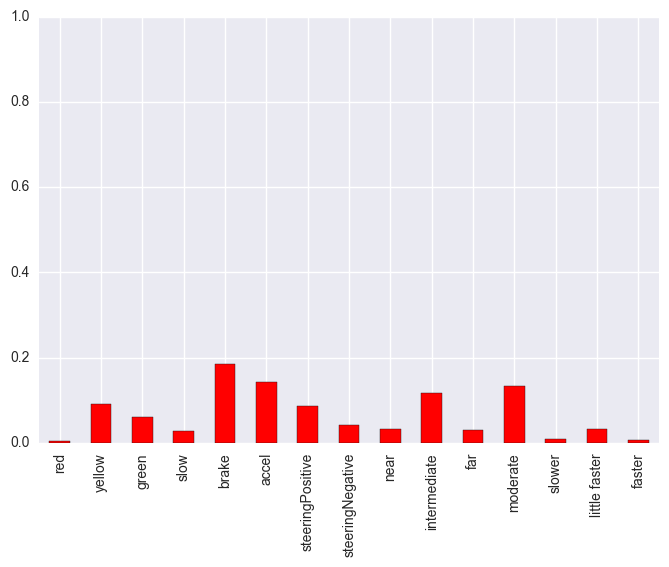

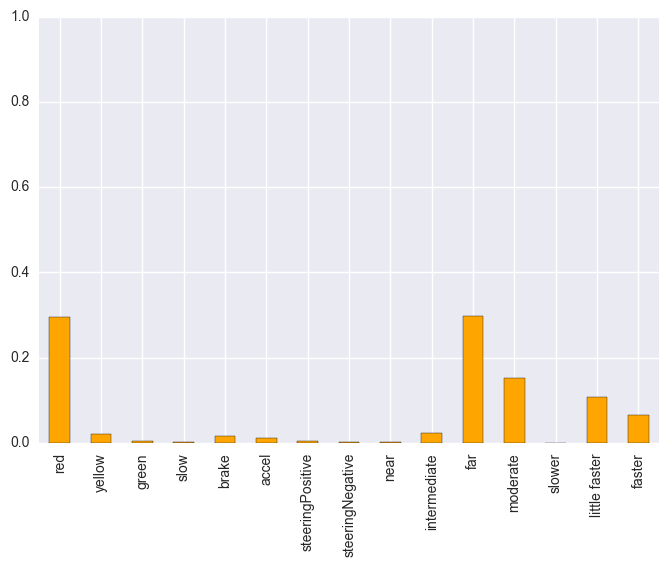

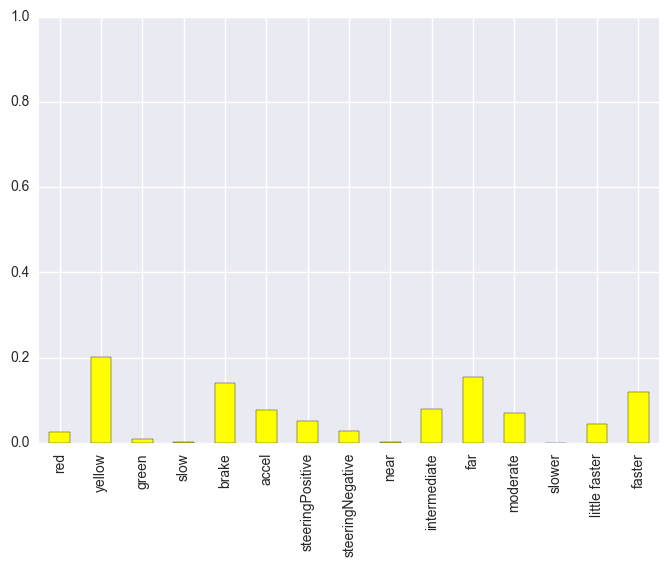

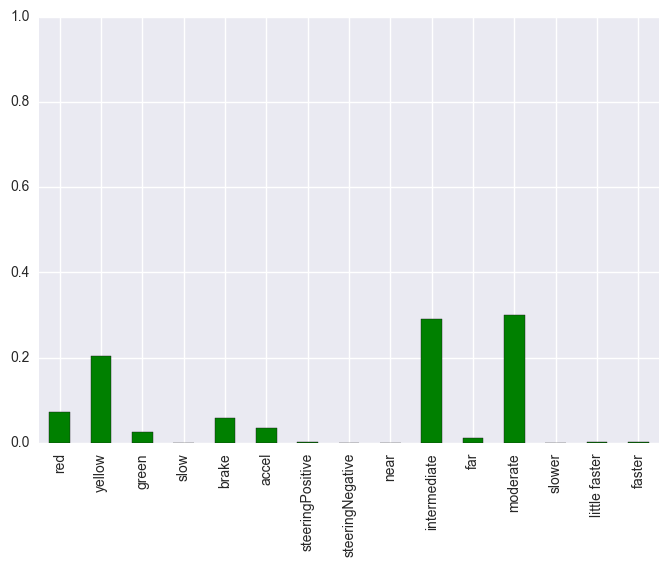

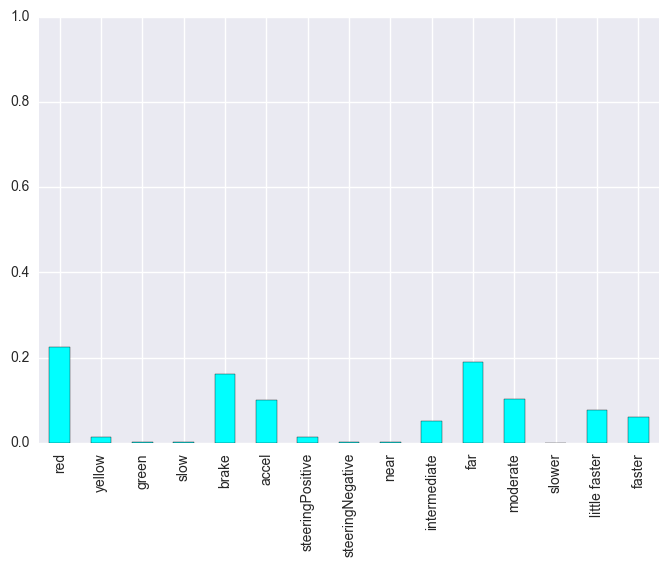

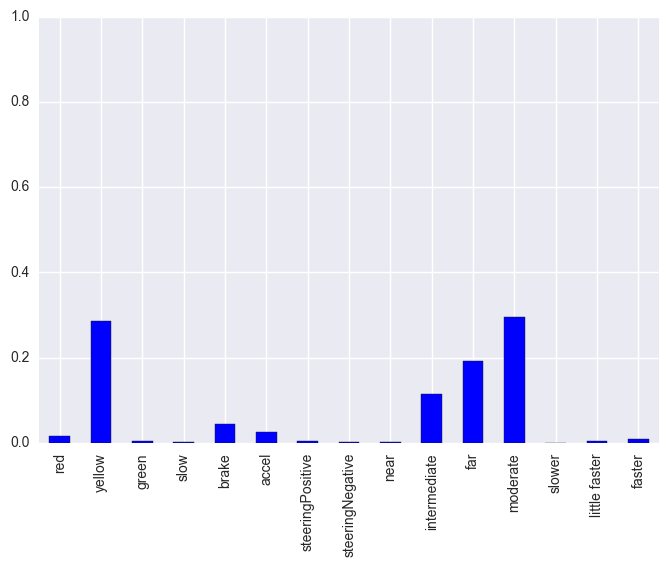

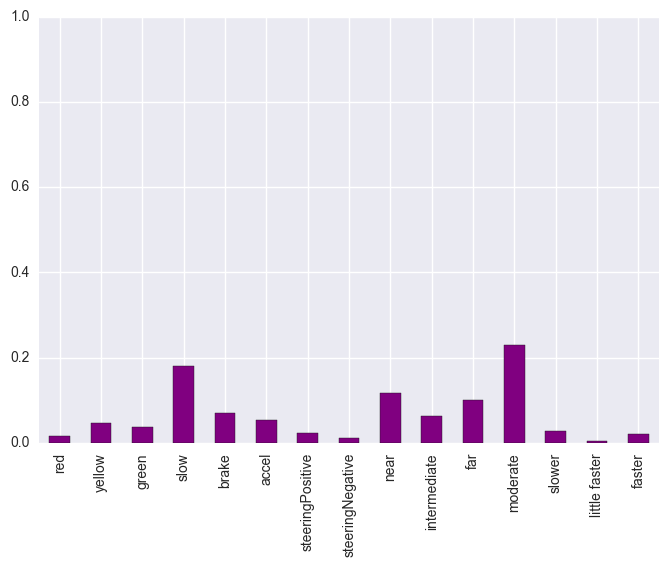

IndexError: list index out of range

In [24]:
dir = "./img/d3/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)
    
resLength = len(set(vb.predict(bf)))
for i in range(resLength):
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

In [ ]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)

# Plot histgram for high risk top 5 

In [ ]:
top5Index = [55, 94, 213, 441, 682]

In [ ]:
mf.ix[682]

In [ ]:
mf.ix[top5Index]

In [ ]:
top5Color = vb.predict(bf.ix[top5Index])

In [ ]:
for i, ic in enumerate(zip(top5Index, top5Color)):
    bf.ix[ic[0]].plot(kind='bar', color=colors[ic[1]])
    plt.ylim(0, 1)
    plt.title(str(top5Index[i]))
    plt.savefig(dir + "/top5-" + str(i+1) + ".png")
    plt.show()